# Reddit Data Extraction

## Import Libraries

In [1]:
import sys
import pandas as pd
import json
import datetime
import re #regex
import requests #APIs
import praw #reddit API enhanced library
import ffn #stock data
from textblob import TextBlob
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf
from tensorflow import keras #lstm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sn
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import pickle

## Read Data

Read data from previous section

In [2]:
df_wsb = pd.read_csv('pos_neg_sent_wsb_full.csv')

In [3]:
df_stocks = pd.read_csv('pos_neg_sent_stocks_full.csv')

In [4]:
df_kw_stocks = pd.read_csv('df_kw_stocks_full.csv')

In [5]:
df_kw_wsb = pd.read_csv('df_kw_wsb_full.csv')

In [6]:
df_stocks

,date,sentiment score,spy,fourier 5,fourier 10,fourier 15,fourier 20,norm_price,spy log,norm_sentiment,norm_fourier5,norm_fourier10,norm_fourier15,norm_fourier20
0,2018-06-11,2.4699,263.560455,(15.90897701445185-1.210142189036728j),(16.31544095797418-0.6496022104660726j),(16.058128626147653-0.2907215495839383j),(17.753337512516577-0.3766330810178123j),0.229770,NaN,0.100938,0.648821,0.571516,0.527222,0.602785
1,2018-06-12,1.2858,263.901062,(15.523985226100498-1.2030929962845092j),(15.47694651129734-0.6607449472604774j),(14.815572148031643-0.33234091444615227j),(15.941579737995024-0.4032254289850287j),0.231544,0.001291,0.079463,0.634754,0.545306,0.490864,0.550726
2,2018-06-13,0.3503,263.058929,(15.136242092500837-1.1935502095773158j),(14.63472065524542-0.6664125433288913j),(13.575659053045868-0.3677693968853928j),(14.104060023853044-0.4164804520454109j),0.227159,-0.003196,0.062497,0.620586,0.518979,0.454583,0.497927
3,2018-06-14,0.1511,263.721283,(14.746115443044582-1.1815336077978462j),(13.791366797409122-0.6665580351853576j),(12.345659943327387-0.3963470313070807j),(12.263820693502964-0.4159597191465118j),0.230607,0.002515,0.058884,0.606330,0.492618,0.418593,0.445050
4,2018-06-15,0.7227,263.384796,(14.353974051856829-1.1670680971882976j),(12.949487439525027-0.6611802172385295j),(11.132742199146278-0.41754147045289797j),(10.444112051688242-0.4016804543604311j),0.228855,-0.001277,0.069250,0.592001,0.466302,0.383102,0.392762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,2021-04-05,35.8456,406.359985,(17.779921814670278-1.2076551611997206j),(20.36242197943935-0.5165278335885646j),(22.05784088772455-0.020074074903710173j),(25.694606748856636-0.08783812412013642j),0.973289,0.014251,0.706239,0.717186,0.698017,0.702776,0.830969
686,2021-04-06,25.8704,406.119995,(17.414135620095113-1.2131888957093853j),(19.58074525184743-0.5527883868923636j),(20.909761430318955-0.07925479611578258j),(24.316499852755875-0.1603944668516503j),0.972040,-0.000591,0.525329,0.703820,0.673584,0.669183,0.791371
687,2021-04-07,30.9270,406.589996,(17.043790848689707-1.2162081109708092j),(18.78276634034733-0.5844683615288923j),(19.728905629065967-0.13695915043205176j),(22.817073836129858-0.22764550648498505j),0.974487,0.001157,0.617035,0.690288,0.648640,0.634630,0.748286
688,2021-04-08,41.9974,408.519989,(16.669243009018825-1.2167065491993059j),(17.970897055633845-0.6113052472511153j),(18.52200269927605-0.19211221491243521j),(21.211415076026192-0.2873668075023479j),0.984536,0.004736,0.817808,0.676602,0.623263,0.599316,0.702149


## Correlation Between Fourier-Normalized Sentiment and Normalized Price

In [10]:
# Stocks Comments Correlation
corrMatrix = df_stocks.corr()

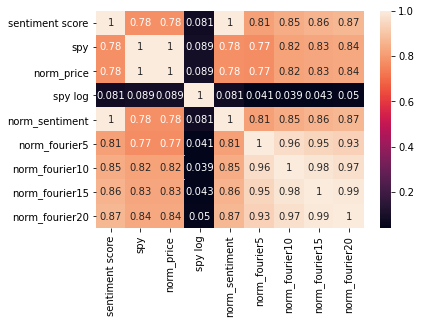

In [11]:
sn.heatmap(corrMatrix, annot=True)
plt.show()

#Source: https://datatofish.com/correlation-matrix-pandas/

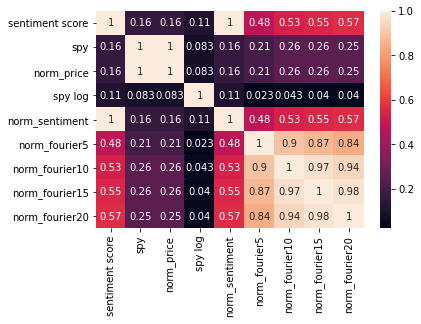

In [12]:
# WSB Comments Correlation 
corrMatrix = df_wsb.corr()

sn.heatmap(corrMatrix, annot=True)
plt.show()

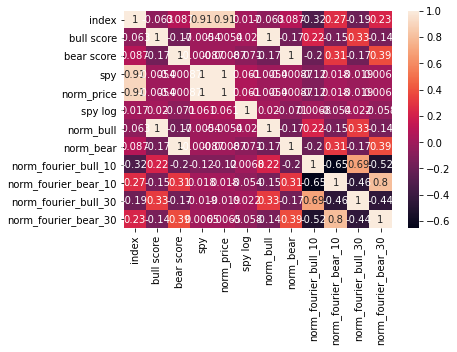

In [13]:
# WSB Keywords Correlation 
corrMatrix = df_kw_wsb.corr()

sn.heatmap(corrMatrix, annot=True)

plt.rcParams['figure.figsize'] = [1, 1]
plt.show()


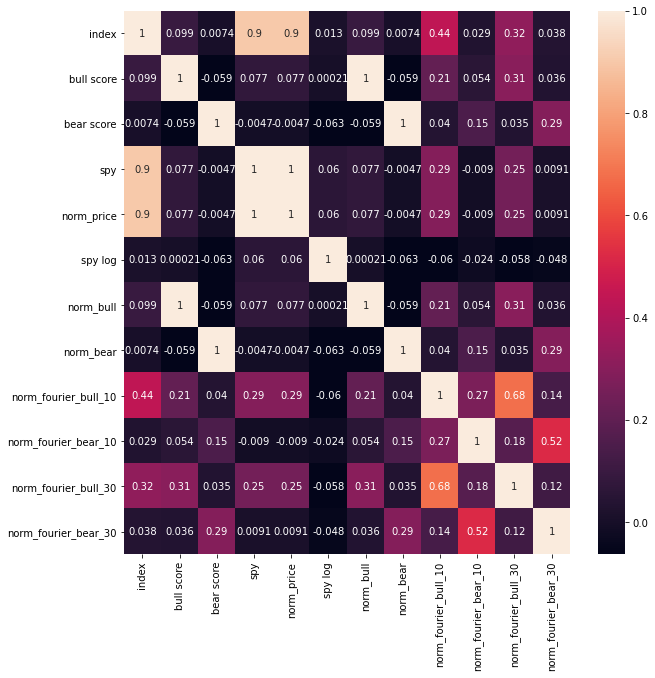

In [164]:
# Stocks Keywords Correlation 
corrMatrix = df_kw_stocks.corr()

sn.heatmap(corrMatrix, annot=True)

plt.rcParams['figure.figsize'] = [100, 100]
plt.show()

#Source: https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger

# LSTM 

In [98]:
# define a function to take the next element in an array
def remove_first(array):
    new_array=[]
    for x in array:
        new_array.append(x[1:])
    return np.asarray(new_array)

## LSTM - Stocks - Comments

Using sentiment to predict next day's price

### Split into Train and Test 

In [99]:
# get relevant columns and divide into train and test sets
df=df_stocks[['norm_price', 'norm_sentiment', 'norm_fourier5', 'norm_fourier10', 
           'norm_fourier15', 'norm_fourier20']].to_numpy()

# 15 day window
window=15

gap=1
data=[]
for x in range(len(df)-window): 
    data.append(df[x:x+window])
data=np.asarray(data)
train=data[:-50]
test=data[-50:]
np.random.shuffle(train)

In [100]:
X_train=[]
y_train=[]
for d in train:
    X_train.append(remove_first(d[:window-gap]))
    y_train.append(d[-1][0])

X_test=[]
y_test=[]
for d in test:
    X_test.append(remove_first(d[:window-gap]))
    y_test.append(d[-1][0])

In [101]:
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)

In [102]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (625, 14, 5)
y_train shape:  (625,)
X_test shape:  (50, 14, 5)
y_test shape:  (50,)


In [103]:
# Initiate Model
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [104]:
# Define Model
mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_comment_sentiment_stocks_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(48, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.LSTM(48,return_sequences=True),
    tf.keras.layers.LSTM(48),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

In [105]:
#Compile Model
model.compile(optimizer='adam', loss='mean_squared_error')#, metrics=['accuracy'])

In [106]:
# Run Model
history = model.fit(X_train, y_train, batch_size=32, validation_data= (X_test, y_test), epochs=250, callbacks=[mc]).history

#Source: https://stackoverflow.com/questions/63427628/tensorflow-throws-me-the-error-valueerror-layer-sequential-expects-1-inputs-bu

Epoch 1/250
20/20 [==============================] - 12s 122ms/step - loss: 0.0779 - val_loss: 0.0540
Epoch 2/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0154 - val_loss: 0.0198
Epoch 3/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0122 - val_loss: 0.0035
Epoch 4/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0130 - val_loss: 0.0028
Epoch 5/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0113 - val_loss: 0.0039
Epoch 6/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0109 - val_loss: 0.0174
Epoch 7/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0128 - val_loss: 0.0054
Epoch 8/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0113 - val_loss: 0.0238
Epoch 9/250
20/20 [==============================] - 0s 24ms/step - loss: 0.0113 - val_loss: 0.0256
Epoch 10/250
20/20 [==============================] - 1s 27ms/step - loss: 0.0101 - val_loss: 0.00

Epoch 82/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0013 - val_loss: 0.0271
Epoch 83/250
20/20 [==============================] - 0s 24ms/step - loss: 0.0018 - val_loss: 0.0359
Epoch 84/250
20/20 [==============================] - 1s 27ms/step - loss: 0.0014 - val_loss: 0.0219
Epoch 85/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0019 - val_loss: 0.0281
Epoch 86/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0233
Epoch 87/250
20/20 [==============================] - 0s 24ms/step - loss: 0.0011 - val_loss: 0.0315
Epoch 88/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0012 - val_loss: 0.0231
Epoch 89/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0011 - val_loss: 0.0241
Epoch 90/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0013 - val_loss: 0.0222
Epoch 91/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0011 - val_los

20/20 [==============================] - 0s 25ms/step - loss: 0.0010 - val_loss: 0.0447
Epoch 162/250
20/20 [==============================] - 0s 24ms/step - loss: 9.8051e-04 - val_loss: 0.0329
Epoch 163/250
20/20 [==============================] - 0s 23ms/step - loss: 9.4154e-04 - val_loss: 0.0322
Epoch 164/250
20/20 [==============================] - 1s 28ms/step - loss: 8.7025e-04 - val_loss: 0.0456
Epoch 165/250
20/20 [==============================] - 0s 23ms/step - loss: 8.9128e-04 - val_loss: 0.0542
Epoch 166/250
20/20 [==============================] - 0s 21ms/step - loss: 9.4183e-04 - val_loss: 0.0266
Epoch 167/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0012 - val_loss: 0.0496
Epoch 168/250
20/20 [==============================] - 0s 21ms/step - loss: 8.5089e-04 - val_loss: 0.0366
Epoch 169/250
20/20 [==============================] - 0s 21ms/step - loss: 8.3183e-04 - val_loss: 0.0259
Epoch 170/250
20/20 [==============================] - 0s 22ms/step 

20/20 [==============================] - 0s 21ms/step - loss: 6.1465e-04 - val_loss: 0.0228
Epoch 239/250
20/20 [==============================] - 0s 21ms/step - loss: 5.0928e-04 - val_loss: 0.0249
Epoch 240/250
20/20 [==============================] - 0s 21ms/step - loss: 7.1138e-04 - val_loss: 0.0162
Epoch 241/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0220
Epoch 242/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 0.0265
Epoch 243/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0199
Epoch 244/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0010 - val_loss: 0.0279
Epoch 245/250
20/20 [==============================] - 0s 21ms/step - loss: 8.4785e-04 - val_loss: 0.0231
Epoch 246/250
20/20 [==============================] - 0s 21ms/step - loss: 6.7741e-04 - val_loss: 0.0274
Epoch 247/250
20/20 [==============================] - 0s 21ms/step - loss: 

<function matplotlib.pyplot.show(close=None, block=None)>

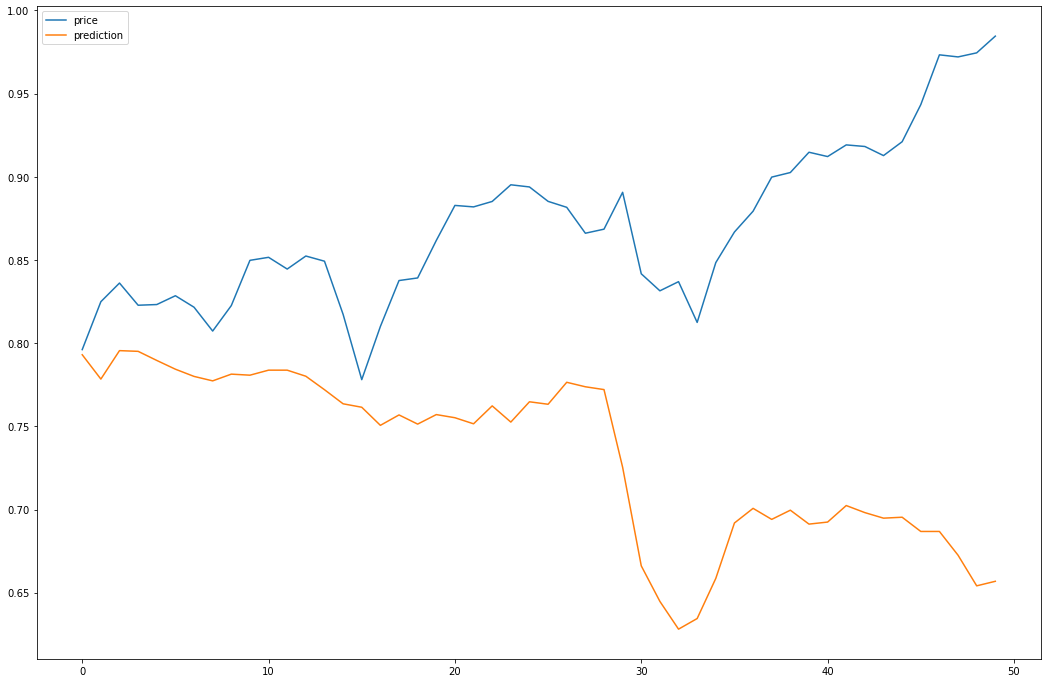

In [107]:
# predictions

pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

In [108]:
print('MAE: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

MAE:  0.1362283506989479


## LSTM - WSB - Comments

Using sentiment to predict next day's price

### Split into Train and Test 

In [109]:
# get relevant columns and divide into train and test sets
df=df_wsb[['norm_price', 'norm_sentiment', 'norm_fourier5', 'norm_fourier10', 
           'norm_fourier15', 'norm_fourier20']].to_numpy()
window=15
gap=1
data=[]
for x in range(len(df)-window): 
    data.append(df[x:x+window])
data=np.asarray(data)
train=data[:-50]
test=data[-50:]
np.random.shuffle(train)

In [110]:
X_train=[]
y_train=[]
for d in train:
    X_train.append(remove_first(d[:window-gap]))
    y_train.append(d[-1][0])

X_test=[]
y_test=[]
for d in test:
    X_test.append(remove_first(d[:window-gap]))
    y_test.append(d[-1][0])

In [111]:
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)

In [112]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (752, 14, 5)
y_train shape:  (752,)
X_test shape:  (50, 14, 5)
y_test shape:  (50,)


In [113]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [114]:
mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_comment_sentiment_stocks_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(48, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.LSTM(48,return_sequences=True),
    tf.keras.layers.LSTM(48),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

In [115]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [116]:
history = model.fit(X_train, y_train, batch_size=32, validation_data= (X_test, y_test), epochs=250, callbacks=[mc]).history

#Source: https://stackoverflow.com/questions/63427628/tensorflow-throws-me-the-error-valueerror-layer-sequential-expects-1-inputs-bu

Epoch 1/250
24/24 [==============================] - 9s 94ms/step - loss: 0.0560 - val_loss: 0.1846
Epoch 2/250
24/24 [==============================] - 0s 20ms/step - loss: 0.0278 - val_loss: 0.3371
Epoch 3/250
24/24 [==============================] - 0s 20ms/step - loss: 0.0283 - val_loss: 0.2618
Epoch 4/250
24/24 [==============================] - 1s 22ms/step - loss: 0.0297 - val_loss: 0.3485
Epoch 5/250
24/24 [==============================] - 0s 20ms/step - loss: 0.0281 - val_loss: 0.3093
Epoch 6/250
24/24 [==============================] - 0s 20ms/step - loss: 0.0261 - val_loss: 0.3290
Epoch 7/250
24/24 [==============================] - 0s 19ms/step - loss: 0.0257 - val_loss: 0.3082
Epoch 8/250
24/24 [==============================] - 0s 20ms/step - loss: 0.0256 - val_loss: 0.3105
Epoch 9/250
24/24 [==============================] - 0s 21ms/step - loss: 0.0293 - val_loss: 0.3062
Epoch 10/250
24/24 [==============================] - 0s 21ms/step - loss: 0.0232 - val_loss: 0.2095

24/24 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.1447
Epoch 83/250
24/24 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 0.1459
Epoch 84/250
24/24 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.1520
Epoch 85/250
24/24 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.1451
Epoch 86/250
24/24 [==============================] - 1s 22ms/step - loss: 0.0013 - val_loss: 0.1496
Epoch 87/250
24/24 [==============================] - 0s 21ms/step - loss: 0.0015 - val_loss: 0.1505
Epoch 88/250
24/24 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 0.1423
Epoch 89/250
24/24 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 0.1385
Epoch 90/250
24/24 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.1551
Epoch 91/250
24/24 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.1459
Epo

24/24 [==============================] - 0s 20ms/step - loss: 8.2600e-04 - val_loss: 0.1622
Epoch 162/250
24/24 [==============================] - 0s 20ms/step - loss: 7.8834e-04 - val_loss: 0.1698
Epoch 163/250
24/24 [==============================] - 0s 21ms/step - loss: 9.1291e-04 - val_loss: 0.1596
Epoch 164/250
24/24 [==============================] - 1s 21ms/step - loss: 8.8267e-04 - val_loss: 0.1624
Epoch 165/250
24/24 [==============================] - 1s 22ms/step - loss: 8.4947e-04 - val_loss: 0.1613
Epoch 166/250
24/24 [==============================] - 1s 22ms/step - loss: 0.0012 - val_loss: 0.1682
Epoch 167/250
24/24 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.1671
Epoch 168/250
24/24 [==============================] - 1s 21ms/step - loss: 9.3101e-04 - val_loss: 0.1756
Epoch 169/250
24/24 [==============================] - 1s 22ms/step - loss: 8.4401e-04 - val_loss: 0.1700
Epoch 170/250
24/24 [==============================] - 0s 21ms/step 

Epoch 239/250
24/24 [==============================] - 1s 22ms/step - loss: 5.8215e-04 - val_loss: 0.1544
Epoch 240/250
24/24 [==============================] - 1s 24ms/step - loss: 5.6660e-04 - val_loss: 0.1488
Epoch 241/250
24/24 [==============================] - 1s 22ms/step - loss: 5.8750e-04 - val_loss: 0.1419
Epoch 242/250
24/24 [==============================] - 1s 25ms/step - loss: 4.6683e-04 - val_loss: 0.1428
Epoch 243/250
24/24 [==============================] - 1s 23ms/step - loss: 6.4080e-04 - val_loss: 0.1524
Epoch 244/250
24/24 [==============================] - 1s 23ms/step - loss: 5.5545e-04 - val_loss: 0.1525
Epoch 245/250
24/24 [==============================] - 1s 22ms/step - loss: 5.8359e-04 - val_loss: 0.1526
Epoch 246/250
24/24 [==============================] - 1s 23ms/step - loss: 5.2334e-04 - val_loss: 0.1526
Epoch 247/250
24/24 [==============================] - 1s 21ms/step - loss: 5.1561e-04 - val_loss: 0.1569
Epoch 248/250
24/24 [=========================

<function matplotlib.pyplot.show(close=None, block=None)>

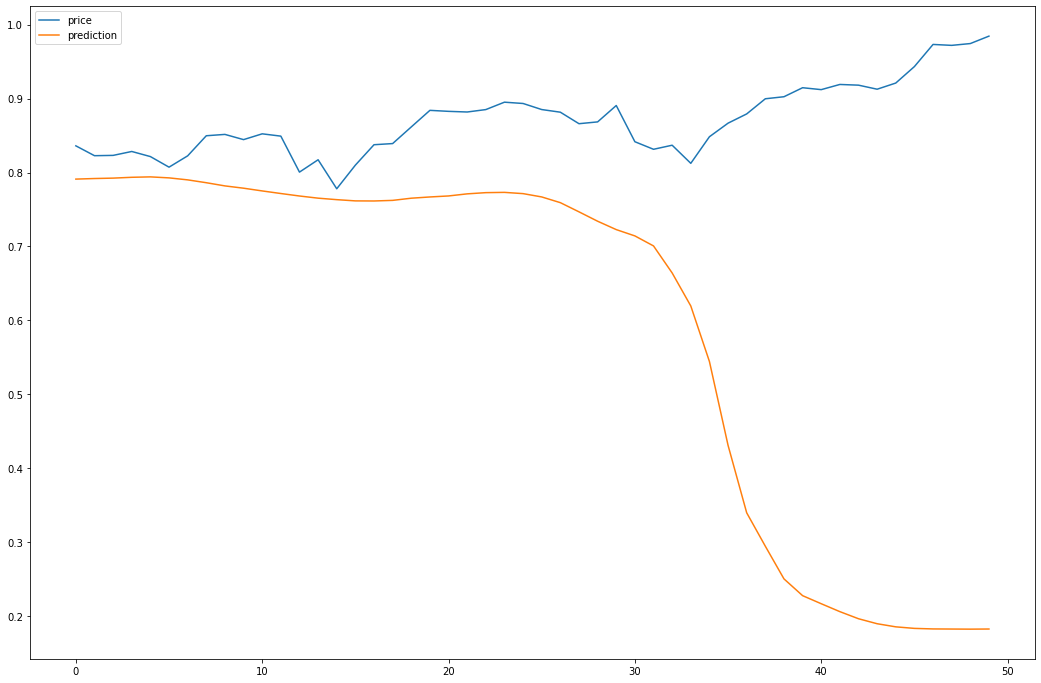

In [117]:
# predictions
pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

In [118]:
print('MAE: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

MAE:  0.2740882080793381


## LSTM - Stocks - Keywords

Using sentiment to predict next day's price

### Split into Train and Test 

In [120]:
# get relevant columns and divide into train and test sets
df=df_kw_stocks[['norm_price', 'norm_bull', 'norm_bear', 'norm_fourier_bull_10', 
           'norm_fourier_bear_10', 'norm_fourier_bull_30', 'norm_fourier_bear_30']].to_numpy()
window=15
gap=1
data=[]
for x in range(len(df)-window): 
    data.append(df[x:x+window])
data=np.asarray(data)
train=data[:-50]
test=data[-50:]
np.random.shuffle(train)

In [121]:
X_train=[]
y_train=[]
for d in train:
    X_train.append(remove_first(d[:window-gap]))
    y_train.append(d[-1][0])

X_test=[]
y_test=[]
for d in test:
    X_test.append(remove_first(d[:window-gap]))
    y_test.append(d[-1][0])

In [122]:
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)

In [123]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (887, 14, 6)
y_train shape:  (887,)
X_test shape:  (50, 14, 6)
y_test shape:  (50,)


In [124]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [125]:
mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_bullbear_sentiment_stocks_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(48, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.LSTM(48,return_sequences=True),
    tf.keras.layers.LSTM(48),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

In [126]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [127]:
history = model.fit(X_train, y_train, batch_size=32, validation_data= (X_test, y_test), epochs=250, callbacks=[mc]).history

#Source: https://stackoverflow.com/questions/63427628/tensorflow-throws-me-the-error-valueerror-layer-sequential-expects-1-inputs-bu

Epoch 1/250
28/28 [==============================] - 11s 95ms/step - loss: 0.0556 - val_loss: 0.2566
Epoch 2/250
28/28 [==============================] - 1s 21ms/step - loss: 0.0295 - val_loss: 0.2740
Epoch 3/250
28/28 [==============================] - 1s 21ms/step - loss: 0.0281 - val_loss: 0.3109
Epoch 4/250
28/28 [==============================] - 1s 22ms/step - loss: 0.0259 - val_loss: 0.3431
Epoch 5/250
28/28 [==============================] - 1s 22ms/step - loss: 0.0277 - val_loss: 0.2768
Epoch 6/250
28/28 [==============================] - 1s 22ms/step - loss: 0.0274 - val_loss: 0.2435
Epoch 7/250
28/28 [==============================] - 1s 21ms/step - loss: 0.0235 - val_loss: 0.2317
Epoch 8/250
28/28 [==============================] - 1s 20ms/step - loss: 0.0187 - val_loss: 0.1408
Epoch 9/250
28/28 [==============================] - 1s 21ms/step - loss: 0.0159 - val_loss: 0.3301
Epoch 10/250
28/28 [==============================] - 1s 24ms/step - loss: 0.0137 - val_loss: 0.266

28/28 [==============================] - 1s 19ms/step - loss: 5.8120e-04 - val_loss: 0.2679
Epoch 82/250
28/28 [==============================] - 1s 19ms/step - loss: 5.8063e-04 - val_loss: 0.2745
Epoch 83/250
28/28 [==============================] - 1s 20ms/step - loss: 6.8458e-04 - val_loss: 0.2951
Epoch 84/250
28/28 [==============================] - 1s 20ms/step - loss: 4.9821e-04 - val_loss: 0.2611
Epoch 85/250
28/28 [==============================] - 1s 21ms/step - loss: 8.7766e-04 - val_loss: 0.2920
Epoch 86/250
28/28 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.2690
Epoch 87/250
28/28 [==============================] - 1s 20ms/step - loss: 6.3551e-04 - val_loss: 0.2842
Epoch 88/250
28/28 [==============================] - 1s 20ms/step - loss: 7.0397e-04 - val_loss: 0.2477
Epoch 89/250
28/28 [==============================] - 1s 19ms/step - loss: 8.5113e-04 - val_loss: 0.2922
Epoch 90/250
28/28 [==============================] - 1s 19ms/step - los

Epoch 159/250
28/28 [==============================] - 1s 20ms/step - loss: 6.0585e-04 - val_loss: 0.2817
Epoch 160/250
28/28 [==============================] - 1s 21ms/step - loss: 3.4169e-04 - val_loss: 0.2807
Epoch 161/250
28/28 [==============================] - 1s 19ms/step - loss: 4.0138e-04 - val_loss: 0.2764
Epoch 162/250
28/28 [==============================] - 1s 20ms/step - loss: 3.7108e-04 - val_loss: 0.2672
Epoch 163/250
28/28 [==============================] - 1s 20ms/step - loss: 2.2520e-04 - val_loss: 0.2827
Epoch 164/250
28/28 [==============================] - 1s 19ms/step - loss: 3.0787e-04 - val_loss: 0.2741
Epoch 165/250
28/28 [==============================] - 1s 20ms/step - loss: 2.8140e-04 - val_loss: 0.2694
Epoch 166/250
28/28 [==============================] - 1s 20ms/step - loss: 3.1924e-04 - val_loss: 0.2842
Epoch 167/250
28/28 [==============================] - 1s 20ms/step - loss: 3.0028e-04 - val_loss: 0.2836
Epoch 168/250
28/28 [=========================

28/28 [==============================] - 1s 19ms/step - loss: 2.5496e-04 - val_loss: 0.2662
Epoch 237/250
28/28 [==============================] - 1s 20ms/step - loss: 2.6981e-04 - val_loss: 0.2658
Epoch 238/250
28/28 [==============================] - 1s 20ms/step - loss: 3.2055e-04 - val_loss: 0.2729
Epoch 239/250
28/28 [==============================] - 1s 20ms/step - loss: 3.2423e-04 - val_loss: 0.2883
Epoch 240/250
28/28 [==============================] - 1s 20ms/step - loss: 3.2830e-04 - val_loss: 0.2685
Epoch 241/250
28/28 [==============================] - 1s 19ms/step - loss: 2.4643e-04 - val_loss: 0.2852
Epoch 242/250
28/28 [==============================] - 1s 20ms/step - loss: 2.3989e-04 - val_loss: 0.2680
Epoch 243/250
28/28 [==============================] - 1s 20ms/step - loss: 3.1025e-04 - val_loss: 0.2836
Epoch 244/250
28/28 [==============================] - 1s 19ms/step - loss: 2.2940e-04 - val_loss: 0.2899
Epoch 245/250
28/28 [==============================] - 1s 19

<function matplotlib.pyplot.show(close=None, block=None)>

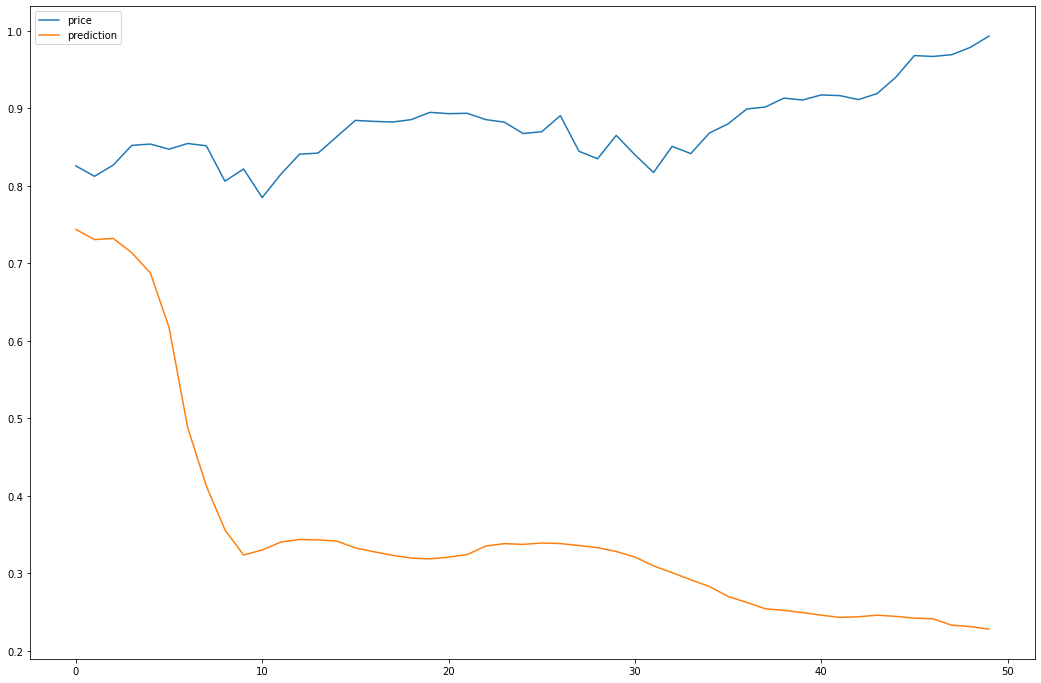

In [128]:
# predictions
pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

In [129]:
print('MAE: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

MAE:  0.5241752111911774


## LSTM - WSB - Keywords

Using sentiment to predict next day's price

### Split into Train and Test 

In [130]:
# get relevant columns and divide into train and test sets
df=df_kw_wsb[['norm_price', 'norm_bull', 'norm_bear', 'norm_fourier_bull_10', 
           'norm_fourier_bear_10', 'norm_fourier_bull_30', 'norm_fourier_bear_30']].to_numpy()
window=15
gap=1
data=[]
for x in range(len(df)-window): 
    data.append(df[x:x+window])
data=np.asarray(data)
train=data[:-50]
test=data[-50:]
np.random.shuffle(train)

In [131]:
X_train=[]
y_train=[]
for d in train:
    X_train.append(remove_first(d[:window-gap]))
    y_train.append(d[-1][0])

X_test=[]
y_test=[]
for d in test:
    X_test.append(remove_first(d[:window-gap]))
    y_test.append(d[-1][0])

In [132]:
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)

In [133]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (1000, 14, 6)
y_train shape:  (1000,)
X_test shape:  (50, 14, 6)
y_test shape:  (50,)


In [134]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [135]:
mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_bullbear_sentiment_wsb_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(48, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.LSTM(48,return_sequences=True),
    tf.keras.layers.LSTM(48),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

#Source: https://keras.io/api/layers/activations/

In [136]:
model.compile(optimizer='adam', loss='mean_squared_error')#, metrics=['accuracy'])

#Accuracy is for classification problems. Removed since this is regression.

#Source: https://stackoverflow.com/questions/45632549/why-is-the-accuracy-for-my-keras-model-always-0-when-training

In [137]:
history = model.fit(X_train, y_train, batch_size=32, validation_data= (X_test, y_test), epochs=250, callbacks=[mc]).history

Epoch 1/250
32/32 [==============================] - 10s 89ms/step - loss: 0.0573 - val_loss: 0.3061
Epoch 2/250
32/32 [==============================] - 1s 19ms/step - loss: 0.0345 - val_loss: 0.3592
Epoch 3/250
32/32 [==============================] - 1s 21ms/step - loss: 0.0351 - val_loss: 0.3322
Epoch 4/250
32/32 [==============================] - 1s 20ms/step - loss: 0.0305 - val_loss: 0.2773
Epoch 5/250
32/32 [==============================] - 1s 19ms/step - loss: 0.0285 - val_loss: 0.2360
Epoch 6/250
32/32 [==============================] - 1s 19ms/step - loss: 0.0242 - val_loss: 0.1904
Epoch 7/250
32/32 [==============================] - 1s 21ms/step - loss: 0.0186 - val_loss: 0.1332
Epoch 8/250
32/32 [==============================] - 1s 21ms/step - loss: 0.0183 - val_loss: 0.2146
Epoch 9/250
32/32 [==============================] - 1s 25ms/step - loss: 0.0189 - val_loss: 0.1141
Epoch 10/250
32/32 [==============================] - 1s 21ms/step - loss: 0.0140 - val_loss: 0.141

32/32 [==============================] - 1s 21ms/step - loss: 8.3434e-04 - val_loss: 0.1179
Epoch 83/250
32/32 [==============================] - 1s 21ms/step - loss: 6.5944e-04 - val_loss: 0.1144
Epoch 84/250
32/32 [==============================] - 1s 21ms/step - loss: 8.4113e-04 - val_loss: 0.1153
Epoch 85/250
32/32 [==============================] - 1s 20ms/step - loss: 5.7687e-04 - val_loss: 0.1166
Epoch 86/250
32/32 [==============================] - 1s 20ms/step - loss: 7.4411e-04 - val_loss: 0.1138
Epoch 87/250
32/32 [==============================] - 1s 19ms/step - loss: 7.8186e-04 - val_loss: 0.1140
Epoch 88/250
32/32 [==============================] - 1s 20ms/step - loss: 8.9618e-04 - val_loss: 0.1095
Epoch 89/250
32/32 [==============================] - 1s 23ms/step - loss: 7.4721e-04 - val_loss: 0.1268
Epoch 90/250
32/32 [==============================] - 1s 22ms/step - loss: 7.3012e-04 - val_loss: 0.1145
Epoch 91/250
32/32 [==============================] - 1s 20ms/step -

Epoch 160/250
32/32 [==============================] - 1s 20ms/step - loss: 3.3411e-04 - val_loss: 0.1141
Epoch 161/250
32/32 [==============================] - 1s 20ms/step - loss: 4.4195e-04 - val_loss: 0.1112
Epoch 162/250
32/32 [==============================] - 1s 21ms/step - loss: 5.3963e-04 - val_loss: 0.1075
Epoch 163/250
32/32 [==============================] - 1s 20ms/step - loss: 5.5643e-04 - val_loss: 0.1133
Epoch 164/250
32/32 [==============================] - 1s 22ms/step - loss: 5.0238e-04 - val_loss: 0.1117
Epoch 165/250
32/32 [==============================] - 1s 21ms/step - loss: 3.8079e-04 - val_loss: 0.1181
Epoch 166/250
32/32 [==============================] - 1s 24ms/step - loss: 3.1427e-04 - val_loss: 0.1237
Epoch 167/250
32/32 [==============================] - 1s 22ms/step - loss: 4.1343e-04 - val_loss: 0.1123
Epoch 168/250
32/32 [==============================] - 1s 20ms/step - loss: 7.2601e-04 - val_loss: 0.1138
Epoch 169/250
32/32 [=========================

32/32 [==============================] - 1s 20ms/step - loss: 3.3809e-04 - val_loss: 0.0996
Epoch 238/250
32/32 [==============================] - 1s 19ms/step - loss: 2.7717e-04 - val_loss: 0.0921
Epoch 239/250
32/32 [==============================] - 1s 19ms/step - loss: 4.6612e-04 - val_loss: 0.0987
Epoch 240/250
32/32 [==============================] - ETA: 0s - loss: 4.9481e-0 - 1s 19ms/step - loss: 4.9351e-04 - val_loss: 0.1028
Epoch 241/250
32/32 [==============================] - 1s 20ms/step - loss: 4.5743e-04 - val_loss: 0.0992
Epoch 242/250
32/32 [==============================] - 1s 20ms/step - loss: 2.8866e-04 - val_loss: 0.1009
Epoch 243/250
32/32 [==============================] - 1s 19ms/step - loss: 3.5302e-04 - val_loss: 0.0954
Epoch 244/250
32/32 [==============================] - 1s 21ms/step - loss: 3.0549e-04 - val_loss: 0.0932
Epoch 245/250
32/32 [==============================] - 1s 22ms/step - loss: 3.7902e-04 - val_loss: 0.0963
Epoch 246/250
32/32 [===========

<function matplotlib.pyplot.show(close=None, block=None)>

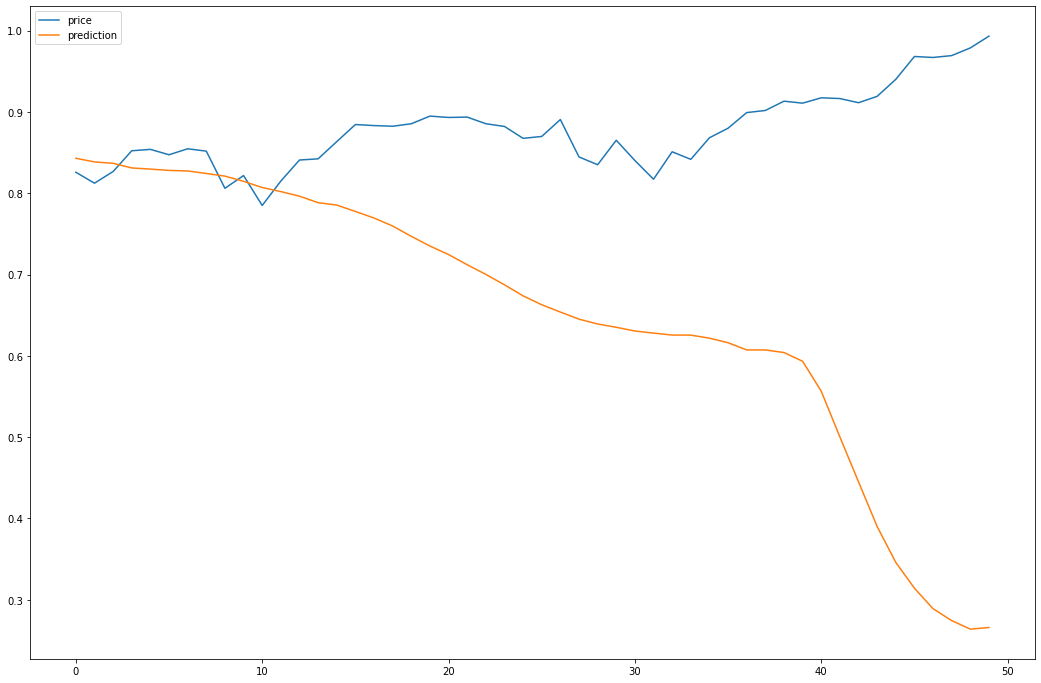

In [138]:
# predictions
pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

In [139]:
print('MAE: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

MAE:  0.22630770087242127


Since the Stocks subreddit Comments model was the most accurate, I will spend time fine tuning that model. 

## LSTM - Stocks - Comments - Expanded

Using sentiment to predict next day's price


### Use the top 3 sentiment transformations most correlated with price

In [140]:
# get relevant columns and divide into train and test sets
df=df_stocks[['norm_price', 'norm_fourier10', 
           'norm_fourier15', 'norm_fourier20']].to_numpy()
window=15
gap=1
data=[]
for x in range(len(df)-window): 
    data.append(df[x:x+window])
data=np.asarray(data)
train=data[:-50]
test=data[-50:]
np.random.shuffle(train)

#Train test
X_train=[]
y_train=[]
for d in train:
    X_train.append(remove_first(d[:window-gap]))
    y_train.append(d[-1][0])

X_test=[]
y_test=[]
for d in test:
    X_test.append(remove_first(d[:window-gap]))
    y_test.append(d[-1][0])
    
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (625, 14, 3)
y_train shape:  (625,)
X_test shape:  (50, 14, 3)
y_test shape:  (50,)


In [141]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_comment_sentiment_stocks_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(48, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.LSTM(48,return_sequences=True),
    tf.keras.layers.LSTM(48),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer='adam', loss='mean_squared_error')#, metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, validation_data= (X_test, y_test), epochs=250, callbacks=[mc]).history

Epoch 1/250
20/20 [==============================] - 10s 162ms/step - loss: 0.0810 - val_loss: 0.0493
Epoch 2/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0152 - val_loss: 0.0125
Epoch 3/250
20/20 [==============================] - 0s 25ms/step - loss: 0.0118 - val_loss: 0.0020
Epoch 4/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0128 - val_loss: 0.0018
Epoch 5/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0113 - val_loss: 0.0059
Epoch 6/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0114 - val_loss: 0.0021
Epoch 7/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0125 - val_loss: 0.0019
Epoch 8/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0114 - val_loss: 0.0049
Epoch 9/250
20/20 [==============================] - 0s 24ms/step - loss: 0.0119 - val_loss: 0.0046
Epoch 10/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0104 - val_loss: 0.00

20/20 [==============================] - 0s 21ms/step - loss: 0.0060 - val_loss: 0.0042
Epoch 83/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0071 - val_loss: 0.0020
Epoch 84/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0071 - val_loss: 0.0025
Epoch 85/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 86/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0064 - val_loss: 0.0020
Epoch 87/250
20/20 [==============================] - 0s 24ms/step - loss: 0.0064 - val_loss: 0.0034
Epoch 88/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0066 - val_loss: 0.0020
Epoch 89/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 90/250
20/20 [==============================] - 1s 28ms/step - loss: 0.0055 - val_loss: 0.0020
Epoch 91/250
20/20 [==============================] - 1s 28ms/step - loss: 0.0054 - val_loss: 0.0045
Epo

20/20 [==============================] - 0s 24ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 163/250
20/20 [==============================] - 1s 34ms/step - loss: 0.0034 - val_loss: 0.0054
Epoch 164/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0032 - val_loss: 0.0054
Epoch 165/250
20/20 [==============================] - 0s 25ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 166/250
20/20 [==============================] - 1s 41ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 167/250
20/20 [==============================] - 0s 25ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 168/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0032 - val_loss: 0.0107
Epoch 169/250
20/20 [==============================] - 1s 26ms/step - loss: 0.0027 - val_loss: 0.0083
Epoch 170/250
20/20 [==============================] - 1s 41ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 171/250
20/20 [==============================] - 1s 29ms/step - loss: 0.0040 - val_loss: 0

20/20 [==============================] - 0s 21ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 243/250
20/20 [==============================] - 0s 24ms/step - loss: 0.0020 - val_loss: 0.0060
Epoch 244/250
20/20 [==============================] - 1s 38ms/step - loss: 0.0024 - val_loss: 0.0061
Epoch 245/250
20/20 [==============================] - 1s 26ms/step - loss: 0.0030 - val_loss: 0.0062
Epoch 246/250
20/20 [==============================] - 1s 26ms/step - loss: 0.0029 - val_loss: 0.0172
Epoch 247/250
20/20 [==============================] - 0s 24ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 248/250
20/20 [==============================] - 0s 24ms/step - loss: 0.0014 - val_loss: 0.0063
Epoch 249/250
20/20 [==============================] - 0s 24ms/step - loss: 0.0025 - val_loss: 0.0086
Epoch 250/250
20/20 [==============================] - 0s 24ms/step - loss: 0.0029 - val_loss: 0.0062


MAE:  0.06651737578213215


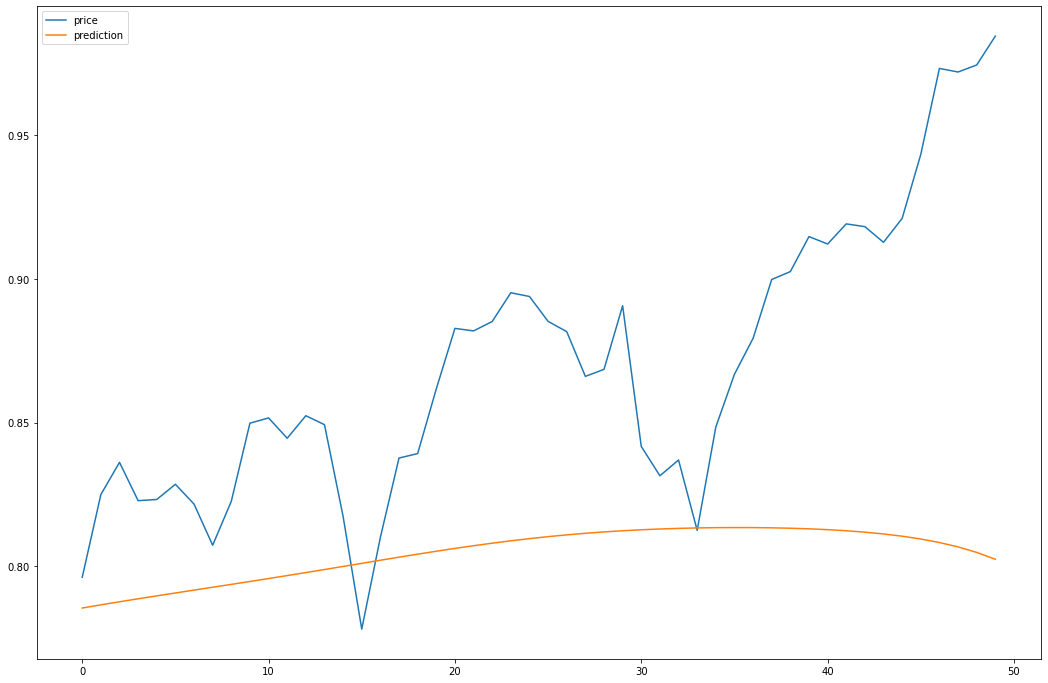

In [142]:
# predictions
pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

print('MAE: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

## Load Data

In [145]:
# get relevant columns and divide into train and test sets
df=df_stocks[['norm_price', 'norm_sentiment', 'norm_fourier5', 'norm_fourier10', 
           'norm_fourier15', 'norm_fourier20']].to_numpy()
window=15
gap=1
data=[]
for x in range(len(df)-window): 
    data.append(df[x:x+window])
data=np.asarray(data)
train=data[:-50]
test=data[-50:]
np.random.shuffle(train)

#Train test
X_train=[]
y_train=[]
for d in train:
    X_train.append(remove_first(d[:window-gap]))
    y_train.append(d[-1][0])

X_test=[]
y_test=[]
for d in test:
    X_test.append(remove_first(d[:window-gap]))
    y_test.append(d[-1][0])
    
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (625, 14, 5)
y_train shape:  (625,)
X_test shape:  (50, 14, 5)
y_test shape:  (50,)


### Add Dense Layer

In [146]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_comment_sentiment_stocks_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(96, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.LSTM(96,return_sequences=True),
    tf.keras.layers.LSTM(96),
    tf.keras.layers.Dense(48, activation="relu"),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=32, validation_data= (X_test, y_test), epochs=250, callbacks=[mc]).history

Epoch 1/250
20/20 [==============================] - 12s 140ms/step - loss: 0.1353 - val_loss: 0.0771
Epoch 2/250
20/20 [==============================] - 1s 32ms/step - loss: 0.0214 - val_loss: 0.0779
Epoch 3/250
20/20 [==============================] - 1s 29ms/step - loss: 0.0161 - val_loss: 0.0301
Epoch 4/250
20/20 [==============================] - 1s 31ms/step - loss: 0.0131 - val_loss: 0.0138
Epoch 5/250
20/20 [==============================] - 1s 30ms/step - loss: 0.0122 - val_loss: 0.0027
Epoch 6/250
20/20 [==============================] - 1s 29ms/step - loss: 0.0128 - val_loss: 0.0050
Epoch 7/250
20/20 [==============================] - 1s 30ms/step - loss: 0.0111 - val_loss: 0.0025
Epoch 8/250
20/20 [==============================] - 1s 30ms/step - loss: 0.0118 - val_loss: 0.0056
Epoch 9/250
20/20 [==============================] - 1s 31ms/step - loss: 0.0110 - val_loss: 0.0034
Epoch 10/250
20/20 [==============================] - 1s 32ms/step - loss: 0.0110 - val_loss: 0.00

20/20 [==============================] - 1s 29ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 83/250
20/20 [==============================] - 1s 29ms/step - loss: 0.0018 - val_loss: 0.0058
Epoch 84/250
20/20 [==============================] - 1s 30ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 85/250
20/20 [==============================] - 1s 29ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 86/250
20/20 [==============================] - 1s 28ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 87/250
20/20 [==============================] - 1s 29ms/step - loss: 0.0017 - val_loss: 0.0054
Epoch 88/250
20/20 [==============================] - 1s 28ms/step - loss: 0.0014 - val_loss: 0.0116
Epoch 89/250
20/20 [==============================] - 1s 30ms/step - loss: 0.0021 - val_loss: 0.0152
Epoch 90/250
20/20 [==============================] - 1s 30ms/step - loss: 0.0019 - val_loss: 0.0060
Epoch 91/250
20/20 [==============================] - 1s 29ms/step - loss: 0.0019 - val_loss: 0.0046
Epo

Epoch 162/250
20/20 [==============================] - 1s 29ms/step - loss: 0.0014 - val_loss: 0.0061
Epoch 163/250
20/20 [==============================] - 1s 29ms/step - loss: 0.0011 - val_loss: 0.0098
Epoch 164/250
20/20 [==============================] - 1s 29ms/step - loss: 8.4572e-04 - val_loss: 0.0127
Epoch 165/250
20/20 [==============================] - 1s 29ms/step - loss: 8.9593e-04 - val_loss: 0.0169
Epoch 166/250
20/20 [==============================] - 1s 28ms/step - loss: 6.3732e-04 - val_loss: 0.0153
Epoch 167/250
20/20 [==============================] - 1s 30ms/step - loss: 6.5610e-04 - val_loss: 0.0191
Epoch 168/250
20/20 [==============================] - ETA: 0s - loss: 7.0658e-0 - 1s 29ms/step - loss: 7.0455e-04 - val_loss: 0.0131
Epoch 169/250
20/20 [==============================] - 1s 29ms/step - loss: 7.5376e-04 - val_loss: 0.0226
Epoch 170/250
20/20 [==============================] - 1s 31ms/step - loss: 8.5312e-04 - val_loss: 0.0190
Epoch 171/250
20/20 [=====

20/20 [==============================] - 1s 34ms/step - loss: 6.7472e-04 - val_loss: 0.0188
Epoch 240/250
20/20 [==============================] - 1s 30ms/step - loss: 6.1741e-04 - val_loss: 0.0180
Epoch 241/250
20/20 [==============================] - 1s 31ms/step - loss: 5.5955e-04 - val_loss: 0.0206
Epoch 242/250
20/20 [==============================] - 1s 29ms/step - loss: 5.4022e-04 - val_loss: 0.0134
Epoch 243/250
20/20 [==============================] - 1s 29ms/step - loss: 5.5355e-04 - val_loss: 0.0203
Epoch 244/250
20/20 [==============================] - 1s 29ms/step - loss: 4.8217e-04 - val_loss: 0.0172
Epoch 245/250
20/20 [==============================] - 1s 35ms/step - loss: 4.8032e-04 - val_loss: 0.0146
Epoch 246/250
20/20 [==============================] - 1s 31ms/step - loss: 3.7290e-04 - val_loss: 0.0154
Epoch 247/250
20/20 [==============================] - 1s 29ms/step - loss: 3.7047e-04 - val_loss: 0.0180
Epoch 248/250
20/20 [==============================] - 1s 31

MAE:  0.11107374668121338


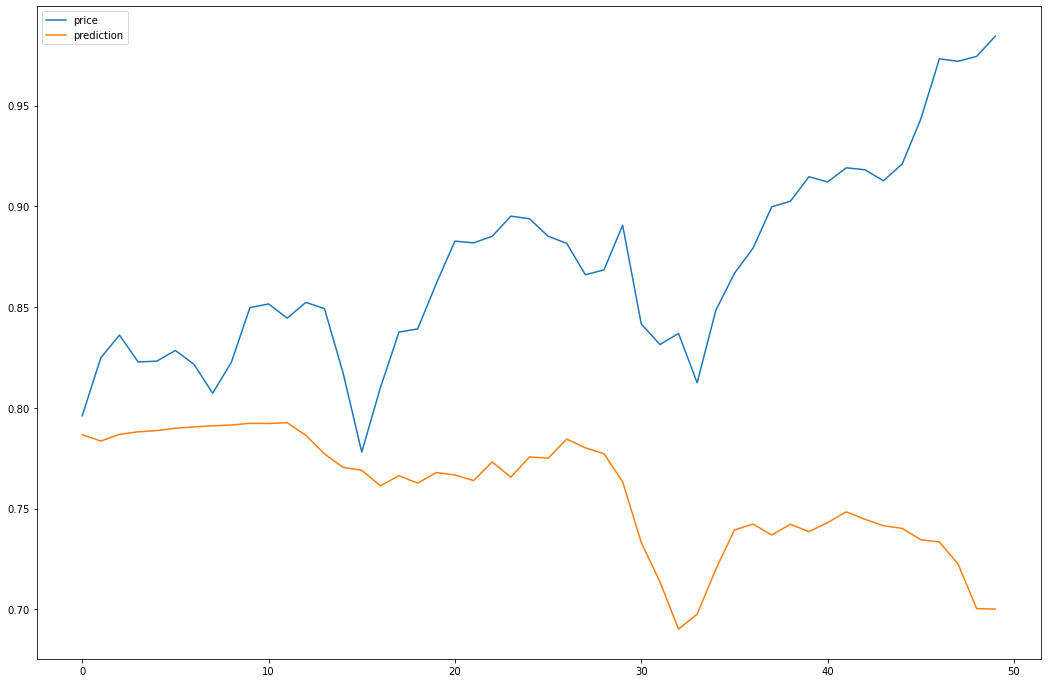

In [147]:
# predictions
pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

print('MAE: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

### Add Dense Layer

Epoch 1/250
20/20 [==============================] - 11s 143ms/step - loss: 0.1237 - val_loss: 0.1208
Epoch 2/250
20/20 [==============================] - 1s 36ms/step - loss: 0.0192 - val_loss: 0.0712
Epoch 3/250
20/20 [==============================] - 1s 35ms/step - loss: 0.0155 - val_loss: 0.0200
Epoch 4/250
20/20 [==============================] - 1s 35ms/step - loss: 0.0132 - val_loss: 0.0047
Epoch 5/250
20/20 [==============================] - 1s 35ms/step - loss: 0.0122 - val_loss: 0.0029
Epoch 6/250
20/20 [==============================] - 1s 36ms/step - loss: 0.0127 - val_loss: 0.0038
Epoch 7/250
20/20 [==============================] - 1s 37ms/step - loss: 0.0111 - val_loss: 0.0039
Epoch 8/250
20/20 [==============================] - 1s 35ms/step - loss: 0.0125 - val_loss: 0.0102
Epoch 9/250
20/20 [==============================] - 1s 35ms/step - loss: 0.0107 - val_loss: 0.0093
Epoch 10/250
20/20 [==============================] - 1s 40ms/step - loss: 0.0110 - val_loss: 0.02

20/20 [==============================] - 1s 33ms/step - loss: 0.0020 - val_loss: 0.0056
Epoch 83/250
20/20 [==============================] - 1s 33ms/step - loss: 0.0019 - val_loss: 0.0064
Epoch 84/250
20/20 [==============================] - 1s 33ms/step - loss: 0.0025 - val_loss: 0.0083
Epoch 85/250
20/20 [==============================] - 1s 33ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 86/250
20/20 [==============================] - 1s 36ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 87/250
20/20 [==============================] - 1s 35ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 88/250
20/20 [==============================] - 1s 36ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 89/250
20/20 [==============================] - 1s 35ms/step - loss: 0.0024 - val_loss: 0.0077
Epoch 90/250
20/20 [==============================] - 1s 36ms/step - loss: 0.0016 - val_loss: 0.0061
Epoch 91/250
20/20 [==============================] - 1s 34ms/step - loss: 0.0016 - val_loss: 0.0069
Epo

20/20 [==============================] - 1s 39ms/step - loss: 0.0016 - val_loss: 0.0054
Epoch 163/250
20/20 [==============================] - 1s 38ms/step - loss: 0.0010 - val_loss: 0.0069
Epoch 164/250
20/20 [==============================] - 1s 35ms/step - loss: 9.6236e-04 - val_loss: 0.0081
Epoch 165/250
20/20 [==============================] - 1s 37ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 166/250
20/20 [==============================] - 1s 40ms/step - loss: 0.0011 - val_loss: 0.0114
Epoch 167/250
20/20 [==============================] - 1s 37ms/step - loss: 9.8381e-04 - val_loss: 0.0150
Epoch 168/250
20/20 [==============================] - 1s 37ms/step - loss: 9.4884e-04 - val_loss: 0.0086
Epoch 169/250
20/20 [==============================] - 1s 36ms/step - loss: 0.0012 - val_loss: 0.0088
Epoch 170/250
20/20 [==============================] - 1s 36ms/step - loss: 8.1548e-04 - val_loss: 0.0114
Epoch 171/250
20/20 [==============================] - 1s 36ms/step - loss: 8.40

Epoch 241/250
20/20 [==============================] - 1s 41ms/step - loss: 5.0003e-04 - val_loss: 0.0105
Epoch 242/250
20/20 [==============================] - 1s 40ms/step - loss: 6.2575e-04 - val_loss: 0.0208
Epoch 243/250
20/20 [==============================] - 1s 39ms/step - loss: 7.6306e-04 - val_loss: 0.0145
Epoch 244/250
20/20 [==============================] - 1s 38ms/step - loss: 5.5276e-04 - val_loss: 0.0130
Epoch 245/250
20/20 [==============================] - 1s 37ms/step - loss: 5.2459e-04 - val_loss: 0.0165
Epoch 246/250
20/20 [==============================] - 1s 36ms/step - loss: 5.5993e-04 - val_loss: 0.0120
Epoch 247/250
20/20 [==============================] - 1s 34ms/step - loss: 5.9146e-04 - val_loss: 0.0152
Epoch 248/250
20/20 [==============================] - 1s 39ms/step - loss: 7.2846e-04 - val_loss: 0.0116
Epoch 249/250
20/20 [==============================] - 1s 34ms/step - loss: 7.2404e-04 - val_loss: 0.0155
Epoch 250/250
20/20 [=========================

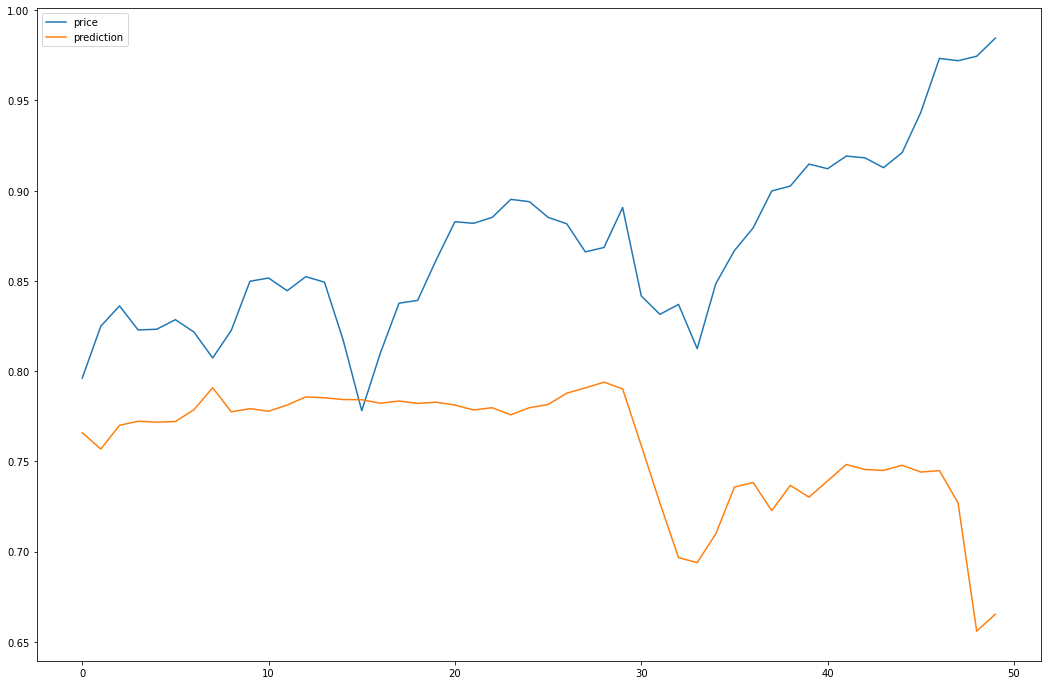

In [149]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_comment_sentiment_stocks_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(96, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(96,return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(96),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(48, activation="relu"),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=32, validation_data= (X_test, y_test), epochs=250, callbacks=[mc]).history

#predictions
pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

print('MAE: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

### Add Dense Layer

Epoch 1/250
20/20 [==============================] - 12s 234ms/step - loss: 0.0967 - val_loss: 0.1165
Epoch 2/250
20/20 [==============================] - 3s 137ms/step - loss: 0.0157 - val_loss: 0.0276
Epoch 3/250
20/20 [==============================] - 3s 145ms/step - loss: 0.0135 - val_loss: 0.0161
Epoch 4/250
20/20 [==============================] - 3s 137ms/step - loss: 0.0121 - val_loss: 0.0036
Epoch 5/250
20/20 [==============================] - 3s 137ms/step - loss: 0.0126 - val_loss: 0.0049
Epoch 6/250
20/20 [==============================] - 3s 133ms/step - loss: 0.0135 - val_loss: 0.0047
Epoch 7/250
20/20 [==============================] - 3s 137ms/step - loss: 0.0120 - val_loss: 0.0104
Epoch 8/250
20/20 [==============================] - 3s 138ms/step - loss: 0.0136 - val_loss: 0.0026
Epoch 9/250
20/20 [==============================] - 3s 144ms/step - loss: 0.0108 - val_loss: 0.0054
Epoch 10/250
20/20 [==============================] - 3s 135ms/step - loss: 0.0113 - val_l

20/20 [==============================] - 3s 142ms/step - loss: 0.0019 - val_loss: 0.0095
Epoch 82/250
20/20 [==============================] - 3s 159ms/step - loss: 0.0035 - val_loss: 0.0112
Epoch 83/250
20/20 [==============================] - 3s 142ms/step - loss: 0.0022 - val_loss: 0.0043
Epoch 84/250
20/20 [==============================] - 3s 148ms/step - loss: 0.0023 - val_loss: 0.0118
Epoch 85/250
20/20 [==============================] - 3s 146ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 86/250
20/20 [==============================] - 3s 162ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 87/250
20/20 [==============================] - 3s 165ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 88/250
20/20 [==============================] - 3s 163ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 89/250
20/20 [==============================] - 3s 144ms/step - loss: 0.0032 - val_loss: 0.0194
Epoch 90/250
20/20 [==============================] - 3s 150ms/step - loss: 0.0026 - val_loss: 

20/20 [==============================] - 3s 142ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 161/250
20/20 [==============================] - 3s 139ms/step - loss: 0.0012 - val_loss: 0.0165
Epoch 162/250
20/20 [==============================] - 3s 139ms/step - loss: 0.0016 - val_loss: 0.0083
Epoch 163/250
20/20 [==============================] - 3s 135ms/step - loss: 0.0017 - val_loss: 0.0135
Epoch 164/250
20/20 [==============================] - 3s 137ms/step - loss: 9.8795e-04 - val_loss: 0.0125
Epoch 165/250
20/20 [==============================] - 3s 151ms/step - loss: 0.0010 - val_loss: 0.0088
Epoch 166/250
20/20 [==============================] - 3s 141ms/step - loss: 9.5574e-04 - val_loss: 0.0150
Epoch 167/250
20/20 [==============================] - 3s 137ms/step - loss: 9.7930e-04 - val_loss: 0.0172
Epoch 168/250
20/20 [==============================] - 3s 138ms/step - loss: 0.0012 - val_loss: 0.0109
Epoch 169/250
20/20 [==============================] - 3s 143ms/step - loss

20/20 [==============================] - 3s 128ms/step - loss: 7.3663e-04 - val_loss: 0.0225
Epoch 239/250
20/20 [==============================] - 3s 127ms/step - loss: 7.4419e-04 - val_loss: 0.0140
Epoch 240/250
20/20 [==============================] - 3s 126ms/step - loss: 4.7894e-04 - val_loss: 0.0143
Epoch 241/250
20/20 [==============================] - 3s 128ms/step - loss: 6.5648e-04 - val_loss: 0.0116
Epoch 242/250
20/20 [==============================] - 3s 134ms/step - loss: 6.0966e-04 - val_loss: 0.0188
Epoch 243/250
20/20 [==============================] - 3s 132ms/step - loss: 9.2256e-04 - val_loss: 0.0270
Epoch 244/250
20/20 [==============================] - 3s 128ms/step - loss: 0.0016 - val_loss: 0.0130
Epoch 245/250
20/20 [==============================] - 3s 130ms/step - loss: 0.0019 - val_loss: 0.0174
Epoch 246/250
20/20 [==============================] - 3s 126ms/step - loss: 8.5421e-04 - val_loss: 0.0113
Epoch 247/250
20/20 [==============================] - 3s 1

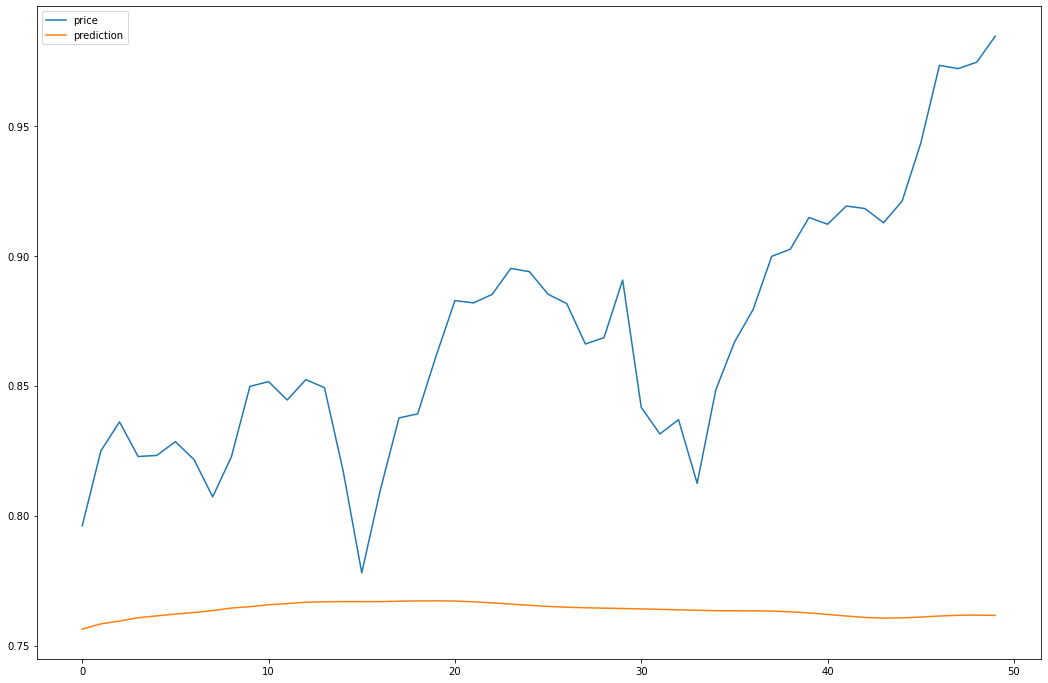

In [151]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_comment_sentiment_stocks_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(384, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(192,return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(96),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(48, activation="relu"),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=32, validation_data= (X_test, y_test), epochs=250, callbacks=[mc]).history

#predictions
pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

print('MAE: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

## Lookback Windows - 30

Try Different Lookback Windows to test accuracy

In [152]:
# get relevant columns and divide into train and test sets
df=df_stocks[['norm_price', 'norm_sentiment', 'norm_fourier5', 'norm_fourier10', 
           'norm_fourier15', 'norm_fourier20']].to_numpy()
window=30
gap=1
data=[]
for x in range(len(df)-window): 
    data.append(df[x:x+window])
data=np.asarray(data)
train=data[:-50]
test=data[-50:]
np.random.shuffle(train)

#Train test
X_train=[]
y_train=[]
for d in train:
    X_train.append(remove_first(d[:window-gap]))
    y_train.append(d[-1][0])

X_test=[]
y_test=[]
for d in test:
    X_test.append(remove_first(d[:window-gap]))
    y_test.append(d[-1][0])
    
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (610, 29, 5)
y_train shape:  (610,)
X_test shape:  (50, 29, 5)
y_test shape:  (50,)


In [153]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_comment_sentiment_stocks_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(96, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(96,return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(96),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(48, activation="relu"),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer='adam', loss='mean_squared_error')#, metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, validation_data= (X_test, y_test), epochs=250, callbacks=[mc]).history

Epoch 1/250
20/20 [==============================] - 11s 175ms/step - loss: 0.1245 - val_loss: 0.0631
Epoch 2/250
20/20 [==============================] - 1s 58ms/step - loss: 0.0141 - val_loss: 0.0179
Epoch 3/250
20/20 [==============================] - 1s 58ms/step - loss: 0.0128 - val_loss: 0.0152
Epoch 4/250
20/20 [==============================] - 1s 59ms/step - loss: 0.0123 - val_loss: 0.0085
Epoch 5/250
20/20 [==============================] - 1s 58ms/step - loss: 0.0126 - val_loss: 0.0020
Epoch 6/250
20/20 [==============================] - 1s 59ms/step - loss: 0.0115 - val_loss: 0.0056
Epoch 7/250
20/20 [==============================] - 1s 60ms/step - loss: 0.0121 - val_loss: 0.0044
Epoch 8/250
20/20 [==============================] - 1s 59ms/step - loss: 0.0127 - val_loss: 0.0215
Epoch 9/250
20/20 [==============================] - 1s 59ms/step - loss: 0.0128 - val_loss: 0.0031
Epoch 10/250
20/20 [==============================] - 1s 62ms/step - loss: 0.0116 - val_loss: 0.01

20/20 [==============================] - 2s 76ms/step - loss: 0.0017 - val_loss: 0.0109
Epoch 82/250
20/20 [==============================] - 1s 67ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 83/250
20/20 [==============================] - 1s 66ms/step - loss: 0.0016 - val_loss: 0.0112
Epoch 84/250
20/20 [==============================] - 2s 85ms/step - loss: 0.0014 - val_loss: 0.0145
Epoch 85/250
20/20 [==============================] - 1s 75ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 86/250
20/20 [==============================] - 1s 73ms/step - loss: 0.0012 - val_loss: 0.0101
Epoch 87/250
20/20 [==============================] - 2s 99ms/step - loss: 0.0016 - val_loss: 0.0073
Epoch 88/250
20/20 [==============================] - 1s 75ms/step - loss: 0.0011 - val_loss: 0.0102
Epoch 89/250
20/20 [==============================] - 2s 87ms/step - loss: 0.0021 - val_loss: 0.0086
Epoch 90/250
20/20 [==============================] - 2s 94ms/step - loss: 0.0016 - val_loss: 0.0068
Epo

20/20 [==============================] - 2s 93ms/step - loss: 9.1552e-04 - val_loss: 0.0123
Epoch 160/250
20/20 [==============================] - 2s 76ms/step - loss: 8.5261e-04 - val_loss: 0.0092
Epoch 161/250
20/20 [==============================] - 1s 71ms/step - loss: 9.3489e-04 - val_loss: 0.0102
Epoch 162/250
20/20 [==============================] - 1s 66ms/step - loss: 7.6960e-04 - val_loss: 0.0069
Epoch 163/250
20/20 [==============================] - 1s 73ms/step - loss: 6.4771e-04 - val_loss: 0.0051
Epoch 164/250
20/20 [==============================] - 2s 78ms/step - loss: 7.5388e-04 - val_loss: 0.0085
Epoch 165/250
20/20 [==============================] - 2s 78ms/step - loss: 9.5647e-04 - val_loss: 0.0045
Epoch 166/250
20/20 [==============================] - 2s 81ms/step - loss: 7.7515e-04 - val_loss: 0.0050
Epoch 167/250
20/20 [==============================] - 2s 76ms/step - loss: 9.8153e-04 - val_loss: 0.0076
Epoch 168/250
20/20 [==============================] - 1s 67

20/20 [==============================] - 1s 62ms/step - loss: 0.0014 - val_loss: 0.0083
Epoch 238/250
20/20 [==============================] - 1s 65ms/step - loss: 8.9883e-04 - val_loss: 0.0138
Epoch 239/250
20/20 [==============================] - 1s 61ms/step - loss: 0.0011 - val_loss: 0.0093
Epoch 240/250
20/20 [==============================] - 1s 61ms/step - loss: 0.0020 - val_loss: 0.0088
Epoch 241/250
20/20 [==============================] - 1s 63ms/step - loss: 0.0011 - val_loss: 0.0078
Epoch 242/250
20/20 [==============================] - 1s 65ms/step - loss: 8.2917e-04 - val_loss: 0.0113
Epoch 243/250
20/20 [==============================] - 1s 67ms/step - loss: 6.4098e-04 - val_loss: 0.0092
Epoch 244/250
20/20 [==============================] - 1s 61ms/step - loss: 5.9545e-04 - val_loss: 0.0094
Epoch 245/250
20/20 [==============================] - 1s 60ms/step - loss: 6.2900e-04 - val_loss: 0.0116
Epoch 246/250
20/20 [==============================] - 1s 59ms/step - loss: 

MAE:  0.08802155077457428


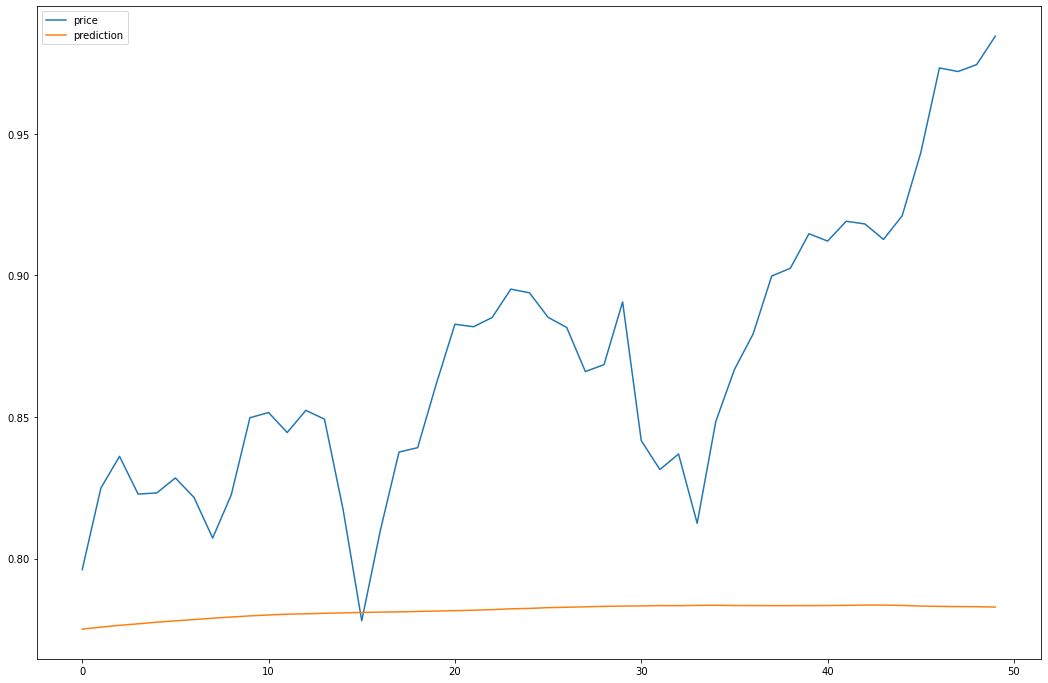

In [154]:
# predictions
pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

print('MAE: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

## Lookback Windows - 7

Try Different Lookback Windows to test accuracy

In [158]:
# get relevant columns and divide into train and test sets
df=df_stocks[['norm_price', 'norm_sentiment', 'norm_fourier5', 'norm_fourier10', 
           'norm_fourier15', 'norm_fourier20']].to_numpy()
window=8
gap=1
data=[]
for x in range(len(df)-window): 
    data.append(df[x:x+window])
data=np.asarray(data)
train=data[:-50]
test=data[-50:]
np.random.shuffle(train)

#Train test
X_train=[]
y_train=[]
for d in train:
    X_train.append(remove_first(d[:window-gap]))
    y_train.append(d[-1][0])

X_test=[]
y_test=[]
for d in test:
    X_test.append(remove_first(d[:window-gap]))
    y_test.append(d[-1][0])
    
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (632, 7, 5)
y_train shape:  (632,)
X_test shape:  (50, 7, 5)
y_test shape:  (50,)


In [159]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_comment_sentiment_stocks_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(96, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(96,return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(96),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(48, activation="relu"),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer='adam', loss='mean_squared_error')#, metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, validation_data= (X_test, y_test), epochs=250, callbacks=[mc]).history

Epoch 1/250
20/20 [==============================] - 11s 140ms/step - loss: 0.1342 - val_loss: 0.0045
Epoch 2/250
20/20 [==============================] - 0s 25ms/step - loss: 0.0191 - val_loss: 0.0131
Epoch 3/250
20/20 [==============================] - 1s 29ms/step - loss: 0.0131 - val_loss: 0.0097
Epoch 4/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0124 - val_loss: 0.0030
Epoch 5/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0130 - val_loss: 0.0034
Epoch 6/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 7/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 8/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0115 - val_loss: 0.0328
Epoch 9/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0126 - val_loss: 0.0282
Epoch 10/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0109 - val_loss: 0.01

20/20 [==============================] - 0s 21ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 83/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 84/250
20/20 [==============================] - 1s 27ms/step - loss: 0.0036 - val_loss: 0.0202
Epoch 85/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 86/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0032 - val_loss: 0.0094
Epoch 87/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0041 - val_loss: 0.0099
Epoch 88/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0044 - val_loss: 0.0106
Epoch 89/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 90/250
20/20 [==============================] - 0s 20ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 91/250
20/20 [==============================] - 0s 20ms/step - loss: 0.0031 - val_loss: 0.0027
Epo

20/20 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 163/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0016 - val_loss: 0.0075
Epoch 164/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0019 - val_loss: 0.0056
Epoch 165/250
20/20 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 166/250
20/20 [==============================] - 0s 19ms/step - loss: 0.0013 - val_loss: 0.0053
Epoch 167/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 168/250
20/20 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 0.0088
Epoch 169/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 170/250
20/20 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 171/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0011 - val_loss: 0

Epoch 242/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0021 - val_loss: 0.0136
Epoch 243/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0011 - val_loss: 0.0103
Epoch 244/250
20/20 [==============================] - 1s 26ms/step - loss: 7.8247e-04 - val_loss: 0.0113
Epoch 245/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0021 - val_loss: 0.0143
Epoch 246/250
20/20 [==============================] - 0s 24ms/step - loss: 0.0034 - val_loss: 0.0109
Epoch 247/250
20/20 [==============================] - 0s 24ms/step - loss: 0.0044 - val_loss: 0.0053
Epoch 248/250
20/20 [==============================] - 0s 22ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 249/250
20/20 [==============================] - 0s 23ms/step - loss: 0.0032 - val_loss: 0.0117
Epoch 250/250
20/20 [==============================] - 0s 25ms/step - loss: 0.0025 - val_loss: 0.0083


MAE:  0.07900940150022506


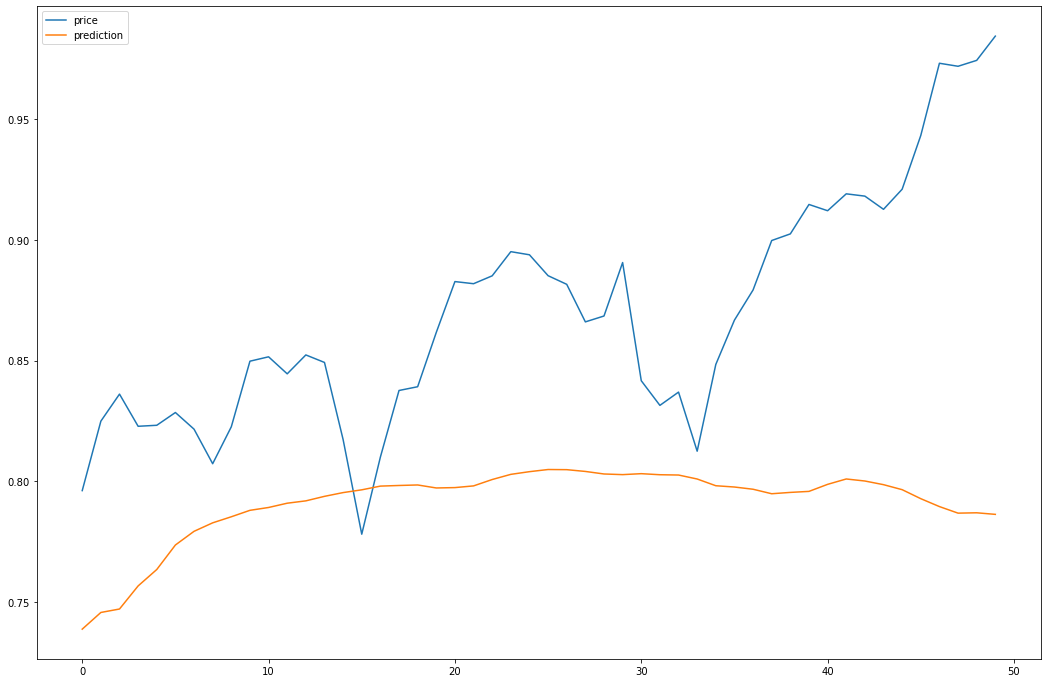

In [160]:
#predictions
pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

print('MAE: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

In [165]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 96)             39168     
_________________________________________________________________
dropout (Dropout)            (None, 7, 96)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 96)             74112     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 96)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 48)                4

Sources: 

https://www.reddit.com/dev/api/

https://praw.readthedocs.io/en/latest/index.html

https://keras.io/api/layers/activations/

https://datatofish.com/correlation-matrix-pandas/

https://medium.com/analytics-vidhya/sentiment-analysis-for-trading-with-reddit-text-data-73729c931d01

https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger

https://stackoverflow.com/questions/63427628/tensorflow-throws-me-the-error-valueerror-layer-sequential-expects-1-inputs-bu

https://stackoverflow.com/questions/45632549/why-is-the-accuracy-for-my-keras-model-always-0-when-training